# Create different versions of Embeddings

## Version control

- V6.1 settings
    - Normal AE with Inception modules
    - No inception modules in the decoder
    - "Normal" meaning no latent variable layers
    - Simple MSEloss
- Difference to V6
    - 2000 images rather than 500
    - 2000 images were chosen randomly when converted to grayscale (500 version wasn't. It just chose the first 500 images)

## Interpretation of v.6 (AE with Inception modules)
- 

In [3]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import itertools
import copy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# images
# import cv2
from PIL import Image
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchviz import make_dot
import gc

In [57]:
def plot_images(path, character_ids):
    # just show first 10 images in 2x5 frame. This method could be made flexible, but there's no need
    rows, columns = 2, 5
    imgs = []
    character_ids = character_ids[:10+1]

    # get the actual images
    for id in character_ids:
        try:
            img = Image.open(path + str(id) + ".png")
            imgs.append(np.array(img))
        except:
            pass

    # iterate over axis and show
    fig, axes = plt.subplots(rows, columns, figsize=(8,4))
    for img, ax in zip(imgs, axes.flatten()):
        ax.imshow(img, cmap="gray")
    plt.show()

---
## Data Prep
---

In [5]:
# check file count
print(len(os.listdir("../assets/character_images/character_images_grayscale_2000/")))

2000


In [6]:
class MangaDataset(Dataset):

    def __init__(self, target_dir, transform_steps=None):
        self.target_dir = target_dir
        self.transform_steps = transform_steps
        self.target_imgs = os.listdir(target_dir)

    def __len__(self):
        return len(self.target_imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.target_dir, self.target_imgs[idx])
        img = Image.open(img_path)

        if self.transform_steps:
            tensor_img = self.transform_steps(img)

        character_id = self.target_imgs[idx].split(".")[0]
        # first is input to the model, second is input for reconstruction, third is the character_id for future ref
        return tensor_img, tensor_img, character_id

In [7]:
# set the steps as a function
def prep_data(data_path, transform_steps, train_ratio, batch_size):
    manga_dataset = MangaDataset(data_path, transform_steps)
    train_size = int(manga_dataset.__len__() * train_ratio)
    val_size = int(manga_dataset.__len__() - train_size)
    train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    all_data_loader = DataLoader(manga_dataset, batch_size=batch_size)
    return train_loader, val_loader, all_data_loader

---
## AE with Inception modules
---

In [8]:
# Codes to build individual modules

# encoder modules
def single_encoder_module(in_c, out_c, k=1, s=1, p=0):
    module = nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p),
                           nn.BatchNorm2d(out_c),
                           nn.ReLU(inplace=True))
    return module

def single_downsampling_module(in_c, pooling):
    module = nn.Sequential(nn.AvgPool2d(pooling),
                           nn.Conv2d(in_c, in_c*pooling, kernel_size=1),
                           nn.BatchNorm2d(in_c*pooling),
                           nn.ReLU(inplace=True))
    return module

In [9]:
# Inception modules

class EncoderInceptionModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        bn_ch = channels // 2
        self.bottleneck = single_encoder_module(channels, bn_ch, 1)
        self.conv1 = single_encoder_module(bn_ch, channels, 1)
        self.conv2 = single_encoder_module(bn_ch, channels, 3, p=1)
        self.conv3 = single_encoder_module(bn_ch, channels, 5, p=2)
        self.conv4 = single_encoder_module(bn_ch, channels, 7, p=3)
        self.pool1 = nn.MaxPool2d(3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(5, stride=1, padding=2)

    def forward(self, x):
        bn = self.bottleneck(x)
        out = self.conv1(bn) + self.conv2(bn) + self.conv3(bn) + self.conv4(bn) + self.pool1(x) + self.pool2(x)
        return out

In [10]:
# Encoder and decoder modules
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        # shallower version
        # self.up_ch1 = nn.Conv2d(1, 32, kernel_size=1)
        # self.e_incep1 = EncoderInceptionModule(32)
        # self.up_ch2 = single_downsampling_module(32, 4)
        # self.e_incep2 = EncoderInceptionModule(128)
        # self.up_ch3 = single_downsampling_module(128, 4)
        # self.e_incep3 = EncoderInceptionModule(512) # [8, 512, 12, 12]

        # deeper version
        self.up_ch1 = nn.Conv2d(1, 32, kernel_size=1)
        self.e_incep1 = EncoderInceptionModule(32)
        self.up_ch2 = single_downsampling_module(32, 2)
        self.e_incep2 = EncoderInceptionModule(64)
        self.up_ch3 = single_downsampling_module(64, 2)
        self.e_incep3 = EncoderInceptionModule(128)
        self.up_ch4 = single_downsampling_module(128, 2)
        self.e_incep4 = EncoderInceptionModule(256)
        self.up_ch5 = single_downsampling_module(256, 2)
        self.e_incep5 = EncoderInceptionModule(512)
        # self.flatten = nn.Flatten(start_dim=1) 

    def forward(self, x):
        # print("x", x.shape)
        out = self.e_incep1(self.up_ch1(x))
        # print("e_incep1", out.shape)
        out = self.e_incep2(self.up_ch2(out))
        # print("e_incep2", out.shape)
        out = self.e_incep3(self.up_ch3(out))
        # print("e_incep3", out.shape)
        out = self.e_incep4(self.up_ch4(out))
        # print("e_incep4", out.shape)
        out = self.e_incep5(self.up_ch5(out))
        # print("e_incep5", out.shape)
        # out = F.avg_pool2d(out, 6)
        # out = self.flatten(out)
        return out


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.down_ch1 = single_upsampling_module_custom(512, 128, k=3, s=2)
        # self.down_ch2 = single_upsampling_module_custom(128, 32, k=3, s=2)
        # self.down_ch3 = single_upsampling_module_custom(32, 1, k=3, s=2, p=1)
        self.conv1 = nn.ConvTranspose2d(512, 256, kernel_size=1, stride=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, output_padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, output_padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.conv5 = nn.ConvTranspose2d(32, 1, kernel_size=1, stride=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.sig5 = nn.Sigmoid()

    def forward(self, x):
        # print("decoder input", x.shape)
        out = self.relu1(self.conv1(x))
        # print("relu1", out.shape)
        out = self.relu2(self.conv2(out))
        # print("relu2", out.shape)
        out = self.relu3(self.conv3(out))
        # print("relu3", out.shape)
        out = self.relu4(self.conv4(out))
        # print("relu4", out.shape)
        out = self.relu5(self.conv5(out))
        # print("relu5", out.shape)
        out = self.sig5(out)
        # print("sig5", out.shape)
        return torch.sigmoid(out)

In [12]:
# AE model with inception modules
class AE_Inception(nn.Module):

    def __init__(self, device):
        super().__init__()
        self.device = device
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

---
## Test runs
---

In [13]:
# !nvidia-smi

In [16]:
# # empty gpu cache
# torch.cuda.empty_cache()

In [15]:
# # test VAE
# transform_steps = transforms.Compose([transforms.ToTensor(),
#                                       transforms.CenterCrop(200),
#                                       # transforms.RandomRotation(90),
#                                       # transforms.RandomHorizontalFlip(),
#                                       # transforms.Normalize(mean=[0], std=[1.0])
#                                      ])
# train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_2000", 
#                                                       transform_steps=transform_steps, train_ratio=0.8, batch_size=32)

# # initialize again, set to train mode, send models to gpu
# device = "cuda" if torch.cuda.is_available() else "cpu"
# # device = "cpu"
# print(device)
# model = AE_Inception(device=device)
# model.train()
# model.to(device)

# # set loss function, optimizer
# criterion = nn.MSELoss()
# ae_params = list(model.parameters())
# optimizer = optim.Adam(ae_params, lr=0.005)

# # train
# losses = []

# for epoch in tqdm(range(10)):
#     running_loss = 0.0
#     for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
#         train_img = train_img.to(device)
#         target_img = target_img.to(device)

#         optimizer.zero_grad()
#         out = model(train_img)
#         # print(type(z), type(target_img))

#         loss = criterion(out, target_img)
#         # loss = bce_kld_loss(z, target_img, mu, log_var)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#         # clean up
#         del train_img, target_img, out
#         gc.collect()
#     avg_loss = running_loss / counter
#     losses.append(avg_loss)

In [17]:
# !nvidia-smi
# # !kill -9 12547

In [18]:
# # quick plot of training losses
# plt.plot(losses)
# print(losses)

In [19]:
# model.eval()

# # validate
# val_losses = []

# for epoch in tqdm(range(10)):
#     with torch.no_grad():
#         running_loss = 0.0
#         for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
#             train_img = train_img.to(device)
#             target_img = target_img.to(device)

#             # forward
#             out = model(train_img)

#             # calculate loss
#             loss = criterion(out, target_img)
#             running_loss += loss.item()
#         avg_loss = running_loss / counter
#         val_losses.append(avg_loss)

In [20]:
# # quick plot of training losses
# plt.plot(val_losses)

---
## Train
---

In [21]:
# !nvidia-smi

In [23]:
# version setting
version = "v6_1"

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

# visualize model
x = torch.zeros(8, 1, 200, 200, dtype=torch.float, requires_grad=False)
model = AE_Inception(device=device)
model.train()
model.to(device)
out = model(x.to(device))
make_dot(out, params=dict(list(model.named_parameters()))).render(version+"_inception_ae_torchviz", format="png")

'v6_1_inception_ae_torchviz.png'

In [25]:
# Putting training and validation into methods
def train_step(model, train_loader, optimizer, device):
    model.train()

    running_loss = 0.0
    for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        optimizer.zero_grad()
        out = model(train_img)
        loss = criterion(out, target_img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # clean up
        del train_img, target_img, out
        gc.collect()

    avg_loss = running_loss / counter
    return avg_loss


def val_step(model, val_loader, device):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)
            out = model(train_img)
            loss = criterion(out, target_img)
            running_loss += loss.item()
            
            # clean up
            del train_img, target_img, out, loss
            gc.collect()

        avg_loss = running_loss / counter
        return avg_loss

In [26]:
# empty gpu cache
torch.cuda.empty_cache()

In [27]:
# train and validate to check that the methods work

# redo the settings all again

# set data
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop(200),
                                      # transforms.RandomRotation(45),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[0], std=[1.0])
                                     ])
train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_2000", 
                                                      transform_steps=transform_steps, train_ratio=0.8, batch_size=32)


# initialize again, set to train mode, send models to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)
model = AE_Inception(device=device)
model.train()
model.to(device)

# set loss function, optimizer
criterion = nn.MSELoss()
ae_params = list(model.parameters())
optimizer = optim.Adam(ae_params, lr=0.001)

# train
losses = []

# check that it works
EPOCHS = 100
train_losses = []
val_losses = []
min_loss = 1e5

for epoch in tqdm(range(1, EPOCHS+1)):
    train_loss = train_step(model, train_loader, optimizer, device=device)
    train_losses.append(train_loss)
    print(f"Epochs = {epoch}, Training Loss : {train_loss}")

    val_loss = val_step(model, val_loader, device=device)
    val_losses.append(val_loss)
    print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

    # Save the best model
    if val_loss < min_loss:
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), "../assets/character_images/models_and_embeddings/best_model_"+version+".pt")
        min_loss = val_loss


cuda


  0%|                                                                                  | 0/100 [00:00<?, ?it/s]

Epochs = 1, Training Loss : 0.09612760663032532


  1%|▋                                                                       | 1/100 [01:26<2:22:49, 86.56s/it]

Epochs = 1, Validation Loss : 0.09629864073716678
Epochs = 2, Training Loss : 0.09151900187134743
Epochs = 2, Validation Loss : 0.0952308252453804


  2%|█▍                                                                      | 2/100 [02:54<2:22:47, 87.42s/it]

Epochs = 3, Training Loss : 0.09065265849232673
Epochs = 3, Validation Loss : 0.09455969643134338


  3%|██▏                                                                     | 3/100 [04:22<2:21:29, 87.52s/it]

Epochs = 4, Training Loss : 0.09046301782131196


  4%|██▉                                                                     | 4/100 [05:50<2:20:23, 87.75s/it]

Epochs = 4, Validation Loss : 0.09473361934606846
Epochs = 5, Training Loss : 0.0902281565964222
Epochs = 5, Validation Loss : 0.09448685726294151


  5%|███▌                                                                    | 5/100 [07:17<2:18:45, 87.64s/it]

Epochs = 6, Training Loss : 0.0901216048002243
Epochs = 6, Validation Loss : 0.09421966339533146


  6%|████▎                                                                   | 6/100 [08:46<2:17:39, 87.87s/it]

Epochs = 7, Training Loss : 0.09001065269112588
Epochs = 7, Validation Loss : 0.09410314949659201


  7%|█████                                                                   | 7/100 [10:13<2:16:10, 87.86s/it]

Epochs = 8, Training Loss : 0.08994681626558304


  8%|█████▊                                                                  | 8/100 [11:40<2:14:19, 87.60s/it]

Epochs = 8, Validation Loss : 0.09423252538992809
Epochs = 9, Training Loss : 0.0898655241727829
Epochs = 9, Validation Loss : 0.09398493056113903


  9%|██████▍                                                                 | 9/100 [13:08<2:12:48, 87.56s/it]

Epochs = 10, Training Loss : 0.08977908909320831
Epochs = 10, Validation Loss : 0.09391728960550748


 10%|███████                                                                | 10/100 [14:35<2:11:16, 87.51s/it]

Epochs = 11, Training Loss : 0.08971389696002006
Epochs = 11, Validation Loss : 0.09387657676751797


 11%|███████▊                                                               | 11/100 [16:03<2:09:52, 87.56s/it]

Epochs = 12, Training Loss : 0.08966074377298355
Epochs = 12, Validation Loss : 0.09380253117818099


 12%|████████▌                                                              | 12/100 [17:31<2:08:27, 87.58s/it]

Epochs = 13, Training Loss : 0.08964637905359268
Epochs = 13, Validation Loss : 0.09376335144042969


 13%|█████████▏                                                             | 13/100 [18:58<2:07:00, 87.59s/it]

Epochs = 14, Training Loss : 0.08959937825798989


 14%|█████████▉                                                             | 14/100 [20:25<2:05:14, 87.37s/it]

Epochs = 14, Validation Loss : 0.09379140860759295
Epochs = 15, Training Loss : 0.0895302064716816
Epochs = 15, Validation Loss : 0.09370145144370887


 15%|██████████▋                                                            | 15/100 [21:53<2:04:09, 87.64s/it]

Epochs = 16, Training Loss : 0.08946877509355546


 16%|███████████▎                                                           | 16/100 [23:20<2:02:26, 87.46s/it]

Epochs = 16, Validation Loss : 0.09372885066729325
Epochs = 17, Training Loss : 0.08946593821048737
Epochs = 17, Validation Loss : 0.09362028653805073


 17%|████████████                                                           | 17/100 [24:49<2:01:15, 87.66s/it]

Epochs = 18, Training Loss : 0.08937739133834839
Epochs = 18, Validation Loss : 0.09361558579481565


 18%|████████████▊                                                          | 18/100 [26:16<1:59:45, 87.62s/it]

Epochs = 19, Training Loss : 0.089359540194273
Epochs = 19, Validation Loss : 0.09358861125432529


 19%|█████████████▍                                                         | 19/100 [27:43<1:58:09, 87.52s/it]

Epochs = 20, Training Loss : 0.08937394097447396


 20%|██████████████▏                                                        | 20/100 [29:11<1:56:36, 87.46s/it]

Epochs = 20, Validation Loss : 0.09458034886763646
Epochs = 21, Training Loss : 0.08933844447135925


 21%|██████████████▉                                                        | 21/100 [30:38<1:55:01, 87.36s/it]

Epochs = 21, Validation Loss : 0.09361608612995881
Epochs = 22, Training Loss : 0.08931270569562912
Epochs = 22, Validation Loss : 0.09355984169703263


 22%|███████████████▌                                                       | 22/100 [32:05<1:53:34, 87.37s/it]

Epochs = 23, Training Loss : 0.08928431257605553
Epochs = 23, Validation Loss : 0.09353099763393402


 23%|████████████████▎                                                      | 23/100 [33:33<1:52:06, 87.36s/it]

Epochs = 24, Training Loss : 0.08928299412131309


 24%|█████████████████                                                      | 24/100 [35:00<1:50:34, 87.29s/it]

Epochs = 24, Validation Loss : 0.0938491362791795
Epochs = 25, Training Loss : 0.08929347276687621
Epochs = 25, Validation Loss : 0.09351476969627234


 25%|█████████████████▊                                                     | 25/100 [36:26<1:48:51, 87.09s/it]

Epochs = 26, Training Loss : 0.08929908916354179
Epochs = 26, Validation Loss : 0.09346993955282065


 26%|██████████████████▍                                                    | 26/100 [37:53<1:47:06, 86.84s/it]

Epochs = 27, Training Loss : 0.08921016201376915
Epochs = 27, Validation Loss : 0.09343479745663129


 27%|███████████████████▏                                                   | 27/100 [39:18<1:45:13, 86.49s/it]

Epochs = 28, Training Loss : 0.08921505093574524


 28%|███████████████████▉                                                   | 28/100 [40:44<1:43:30, 86.25s/it]

Epochs = 28, Validation Loss : 0.09405765338585927
Epochs = 29, Training Loss : 0.08920433923602104


 29%|████████████████████▌                                                  | 29/100 [42:10<1:41:51, 86.07s/it]

Epochs = 29, Validation Loss : 0.09344097054921664
Epochs = 30, Training Loss : 0.08918724596500396


 30%|█████████████████████▎                                                 | 30/100 [43:35<1:40:12, 85.90s/it]

Epochs = 30, Validation Loss : 0.09350096033169673
Epochs = 31, Training Loss : 0.08920803427696228


 31%|██████████████████████                                                 | 31/100 [45:02<1:39:14, 86.30s/it]

Epochs = 31, Validation Loss : 0.0934715408545274
Epochs = 32, Training Loss : 0.08912120610475541
Epochs = 32, Validation Loss : 0.09335629527385418


 32%|██████████████████████▋                                                | 32/100 [46:30<1:38:10, 86.62s/it]

Epochs = 33, Training Loss : 0.08912912875413895


 33%|███████████████████████▍                                               | 33/100 [47:57<1:37:05, 86.95s/it]

Epochs = 33, Validation Loss : 0.09336856179512464
Epochs = 34, Training Loss : 0.08911197513341904


 34%|████████████████████████▏                                              | 34/100 [49:24<1:35:40, 86.98s/it]

Epochs = 34, Validation Loss : 0.09342187069929563
Epochs = 35, Training Loss : 0.0891409932076931


 35%|████████████████████████▊                                              | 35/100 [50:52<1:34:31, 87.25s/it]

Epochs = 35, Validation Loss : 0.09338172869040416
Epochs = 36, Training Loss : 0.08915474131703377


 36%|█████████████████████████▌                                             | 36/100 [52:19<1:33:00, 87.20s/it]

Epochs = 36, Validation Loss : 0.09368654627066392
Epochs = 37, Training Loss : 0.08911452427506447
Epochs = 37, Validation Loss : 0.09332203578490478


 37%|██████████████████████████▎                                            | 37/100 [53:48<1:31:50, 87.47s/it]

Epochs = 38, Training Loss : 0.08909282773733139
Epochs = 38, Validation Loss : 0.09331395477056503


 38%|██████████████████████████▉                                            | 38/100 [55:14<1:30:13, 87.32s/it]

Epochs = 39, Training Loss : 0.08909079909324646


 39%|███████████████████████████▋                                           | 39/100 [56:41<1:28:38, 87.19s/it]

Epochs = 39, Validation Loss : 0.09332731538094007
Epochs = 40, Training Loss : 0.08904316186904908
Epochs = 40, Validation Loss : 0.09330289295086494


 40%|████████████████████████████▍                                          | 40/100 [58:09<1:27:19, 87.32s/it]

Epochs = 41, Training Loss : 0.08905339226126671


 41%|█████████████████████████████                                          | 41/100 [59:36<1:25:43, 87.18s/it]

Epochs = 41, Validation Loss : 0.09331636188121942
Epochs = 42, Training Loss : 0.08902990981936455
Epochs = 42, Validation Loss : 0.09326151873056705


 42%|████████████████████████████▉                                        | 42/100 [1:01:03<1:24:23, 87.31s/it]

Epochs = 43, Training Loss : 0.0890144245326519


 43%|█████████████████████████████▋                                       | 43/100 [1:02:30<1:22:49, 87.18s/it]

Epochs = 43, Validation Loss : 0.09328529410637341
Epochs = 44, Training Loss : 0.08903857544064522


 44%|██████████████████████████████▎                                      | 44/100 [1:03:57<1:21:20, 87.16s/it]

Epochs = 44, Validation Loss : 0.09329326852009846
Epochs = 45, Training Loss : 0.08902182444930076


 45%|███████████████████████████████                                      | 45/100 [1:05:24<1:19:46, 87.03s/it]

Epochs = 45, Validation Loss : 0.09326478552359801
Epochs = 46, Training Loss : 0.08903005614876747


 46%|███████████████████████████████▋                                     | 46/100 [1:06:52<1:18:30, 87.24s/it]

Epochs = 46, Validation Loss : 0.09329158010391089
Epochs = 47, Training Loss : 0.08901385933160783


 47%|████████████████████████████████▍                                    | 47/100 [1:08:19<1:16:55, 87.08s/it]

Epochs = 47, Validation Loss : 0.09340401624257748
Epochs = 48, Training Loss : 0.08900630623102188


 48%|█████████████████████████████████                                    | 48/100 [1:09:46<1:15:34, 87.20s/it]

Epochs = 48, Validation Loss : 0.09333878354384349
Epochs = 49, Training Loss : 0.08901084572076798


 49%|█████████████████████████████████▊                                   | 49/100 [1:11:13<1:14:04, 87.14s/it]

Epochs = 49, Validation Loss : 0.09335469626463376
Epochs = 50, Training Loss : 0.08898064106702805


 50%|██████████████████████████████████▌                                  | 50/100 [1:12:40<1:12:34, 87.09s/it]

Epochs = 50, Validation Loss : 0.09326279277984913
Epochs = 51, Training Loss : 0.08898566260933877


 51%|███████████████████████████████████▏                                 | 51/100 [1:14:08<1:11:13, 87.21s/it]

Epochs = 51, Validation Loss : 0.0933136842571772
Epochs = 52, Training Loss : 0.08897400304675102


 52%|███████████████████████████████████▉                                 | 52/100 [1:15:35<1:09:42, 87.14s/it]

Epochs = 52, Validation Loss : 0.09327289863274647
Epochs = 53, Training Loss : 0.0889705941081047
Epochs = 53, Validation Loss : 0.09324397433262605


 53%|████████████████████████████████████▌                                | 53/100 [1:17:02<1:08:24, 87.32s/it]

Epochs = 54, Training Loss : 0.08895854473114014


 54%|█████████████████████████████████████▎                               | 54/100 [1:18:29<1:06:41, 87.00s/it]

Epochs = 54, Validation Loss : 0.09327611957605068
Epochs = 55, Training Loss : 0.0889773428440094
Epochs = 55, Validation Loss : 0.09321134136273311


 55%|█████████████████████████████████████▉                               | 55/100 [1:19:55<1:05:13, 86.96s/it]

Epochs = 56, Training Loss : 0.08895085573196411


 56%|██████████████████████████████████████▋                              | 56/100 [1:21:22<1:03:40, 86.82s/it]

Epochs = 56, Validation Loss : 0.09326775314716193
Epochs = 57, Training Loss : 0.0889519838988781


 57%|███████████████████████████████████████▎                             | 57/100 [1:22:49<1:02:12, 86.79s/it]

Epochs = 57, Validation Loss : 0.09322330699517177
Epochs = 58, Training Loss : 0.08894342496991157


 58%|████████████████████████████████████████                             | 58/100 [1:24:15<1:00:39, 86.65s/it]

Epochs = 58, Validation Loss : 0.09322856022761418
Epochs = 59, Training Loss : 0.08896878600120545


 59%|█████████████████████████████████████████▉                             | 59/100 [1:25:41<59:04, 86.46s/it]

Epochs = 59, Validation Loss : 0.09341314033820079
Epochs = 60, Training Loss : 0.08896903648972511


 60%|██████████████████████████████████████████▌                            | 60/100 [1:27:08<57:39, 86.50s/it]

Epochs = 60, Validation Loss : 0.09327479509206918
Epochs = 61, Training Loss : 0.08890899389982224
Epochs = 61, Validation Loss : 0.09316253662109375


 61%|███████████████████████████████████████████▎                           | 61/100 [1:28:34<56:13, 86.51s/it]

Epochs = 62, Training Loss : 0.08891165614128113


 62%|████████████████████████████████████████████                           | 62/100 [1:30:00<54:45, 86.45s/it]

Epochs = 62, Validation Loss : 0.09319204837083817
Epochs = 63, Training Loss : 0.0889313854277134


 63%|████████████████████████████████████████████▋                          | 63/100 [1:31:26<53:12, 86.27s/it]

Epochs = 63, Validation Loss : 0.09331070402493843
Epochs = 64, Training Loss : 0.08893058910965919
Epochs = 64, Validation Loss : 0.09315341596419995


 64%|█████████████████████████████████████████████▍                         | 64/100 [1:32:53<51:52, 86.45s/it]

Epochs = 65, Training Loss : 0.08889585569500923


 65%|██████████████████████████████████████████████▏                        | 65/100 [1:34:19<50:19, 86.28s/it]

Epochs = 65, Validation Loss : 0.0931749246441401
Epochs = 66, Training Loss : 0.08890797764062881


 66%|██████████████████████████████████████████████▊                        | 66/100 [1:35:46<48:56, 86.37s/it]

Epochs = 66, Validation Loss : 0.09320313196915847
Epochs = 67, Training Loss : 0.08890642613172531


 67%|███████████████████████████████████████████████▌                       | 67/100 [1:37:12<47:29, 86.36s/it]

Epochs = 67, Validation Loss : 0.09321909799025609
Epochs = 68, Training Loss : 0.08890321940183639


 68%|████████████████████████████████████████████████▎                      | 68/100 [1:38:38<46:00, 86.27s/it]

Epochs = 68, Validation Loss : 0.09350753518251273
Epochs = 69, Training Loss : 0.08889036059379578


 69%|████████████████████████████████████████████████▉                      | 69/100 [1:40:04<44:35, 86.32s/it]

Epochs = 69, Validation Loss : 0.09315422291939075
Epochs = 70, Training Loss : 0.08890226289629936


 70%|█████████████████████████████████████████████████▋                     | 70/100 [1:41:30<43:05, 86.19s/it]

Epochs = 70, Validation Loss : 0.09319266734214929
Epochs = 71, Training Loss : 0.08887957230210304


 71%|██████████████████████████████████████████████████▍                    | 71/100 [1:42:57<41:41, 86.26s/it]

Epochs = 71, Validation Loss : 0.09317934742340675
Epochs = 72, Training Loss : 0.08886853247880935


 72%|███████████████████████████████████████████████████                    | 72/100 [1:44:23<40:13, 86.20s/it]

Epochs = 72, Validation Loss : 0.09317791519256738
Epochs = 73, Training Loss : 0.08887489214539528


 73%|███████████████████████████████████████████████████▊                   | 73/100 [1:45:50<38:52, 86.38s/it]

Epochs = 73, Validation Loss : 0.09317573389181724
Epochs = 74, Training Loss : 0.08889252543449402


 74%|████████████████████████████████████████████████████▌                  | 74/100 [1:47:16<37:22, 86.26s/it]

Epochs = 74, Validation Loss : 0.09316464055043
Epochs = 75, Training Loss : 0.08886249899864197


 75%|█████████████████████████████████████████████████████▎                 | 75/100 [1:48:41<35:53, 86.15s/it]

Epochs = 75, Validation Loss : 0.09316521367201439
Epochs = 76, Training Loss : 0.0888465964794159


 76%|█████████████████████████████████████████████████████▉                 | 76/100 [1:50:08<34:30, 86.26s/it]

Epochs = 76, Validation Loss : 0.09333129742970833
Epochs = 77, Training Loss : 0.08886989325284958


 77%|██████████████████████████████████████████████████████▋                | 77/100 [1:51:34<33:02, 86.19s/it]

Epochs = 77, Validation Loss : 0.0932435135428722
Epochs = 78, Training Loss : 0.08885585859417916


 78%|███████████████████████████████████████████████████████▍               | 78/100 [1:53:01<31:38, 86.31s/it]

Epochs = 78, Validation Loss : 0.0932080321587049
Epochs = 79, Training Loss : 0.08885104283690452


 79%|████████████████████████████████████████████████████████               | 79/100 [1:54:26<30:09, 86.18s/it]

Epochs = 79, Validation Loss : 0.09326107742694709
Epochs = 80, Training Loss : 0.08885360315442085
Epochs = 80, Validation Loss : 0.09314448902240166


 80%|████████████████████████████████████████████████████████▊              | 80/100 [1:55:54<28:49, 86.46s/it]

Epochs = 81, Training Loss : 0.08884743452072144


 81%|█████████████████████████████████████████████████████████▌             | 81/100 [1:57:19<27:19, 86.27s/it]

Epochs = 81, Validation Loss : 0.09315737508810483
Epochs = 82, Training Loss : 0.0888285180926323
Epochs = 82, Validation Loss : 0.09312141457429299


 82%|██████████████████████████████████████████████████████████▏            | 82/100 [1:58:46<25:56, 86.49s/it]

Epochs = 83, Training Loss : 0.08883140265941619


 83%|██████████████████████████████████████████████████████████▉            | 83/100 [2:00:13<24:28, 86.40s/it]

Epochs = 83, Validation Loss : 0.09318475998364963
Epochs = 84, Training Loss : 0.08882207229733467


 84%|███████████████████████████████████████████████████████████▋           | 84/100 [2:01:39<23:00, 86.27s/it]

Epochs = 84, Validation Loss : 0.09314076602458954
Epochs = 85, Training Loss : 0.08883057653903961


 85%|████████████████████████████████████████████████████████████▎          | 85/100 [2:03:05<21:34, 86.29s/it]

Epochs = 85, Validation Loss : 0.09312156530526969
Epochs = 86, Training Loss : 0.08884064480662346


 86%|█████████████████████████████████████████████████████████████          | 86/100 [2:04:31<20:07, 86.22s/it]

Epochs = 86, Validation Loss : 0.09317120909690857
Epochs = 87, Training Loss : 0.08886865749955178


 87%|█████████████████████████████████████████████████████████████▊         | 87/100 [2:05:57<18:42, 86.31s/it]

Epochs = 87, Validation Loss : 0.09318836778402328
Epochs = 88, Training Loss : 0.08882652133703232
Epochs = 88, Validation Loss : 0.0931164576457097


 88%|██████████████████████████████████████████████████████████████▍        | 88/100 [2:07:24<17:16, 86.38s/it]

Epochs = 89, Training Loss : 0.08881659626960754


 89%|███████████████████████████████████████████████████████████████▏       | 89/100 [2:08:51<15:52, 86.56s/it]

Epochs = 89, Validation Loss : 0.0931341928931383
Epochs = 90, Training Loss : 0.08883904501795768


 90%|███████████████████████████████████████████████████████████████▉       | 90/100 [2:10:17<14:23, 86.38s/it]

Epochs = 90, Validation Loss : 0.09350457500952941
Epochs = 91, Training Loss : 0.0888660068809986


 91%|████████████████████████████████████████████████████████████████▌      | 91/100 [2:11:43<12:56, 86.32s/it]

Epochs = 91, Validation Loss : 0.09320191351267007
Epochs = 92, Training Loss : 0.08881712511181832
Epochs = 92, Validation Loss : 0.09310133640582745


 92%|█████████████████████████████████████████████████████████████████▎     | 92/100 [2:13:10<11:31, 86.44s/it]

Epochs = 93, Training Loss : 0.08881305530667305


 93%|██████████████████████████████████████████████████████████████████     | 93/100 [2:14:36<10:03, 86.25s/it]

Epochs = 93, Validation Loss : 0.09317422486268558
Epochs = 94, Training Loss : 0.08882715061306953


 94%|██████████████████████████████████████████████████████████████████▋    | 94/100 [2:16:02<08:38, 86.37s/it]

Epochs = 94, Validation Loss : 0.09313341058217563
Epochs = 95, Training Loss : 0.08882093876600265


 95%|███████████████████████████████████████████████████████████████████▍   | 95/100 [2:17:28<07:11, 86.28s/it]

Epochs = 95, Validation Loss : 0.0931381623332317
Epochs = 96, Training Loss : 0.08881312042474747


 96%|████████████████████████████████████████████████████████████████████▏  | 96/100 [2:18:55<05:45, 86.39s/it]

Epochs = 96, Validation Loss : 0.09319705802660722
Epochs = 97, Training Loss : 0.08878294512629509
Epochs = 97, Validation Loss : 0.09309468991481341


 97%|████████████████████████████████████████████████████████████████████▊  | 97/100 [2:20:22<04:19, 86.44s/it]

Epochs = 98, Training Loss : 0.0888314488530159


 98%|█████████████████████████████████████████████████████████████████████▌ | 98/100 [2:21:48<02:52, 86.50s/it]

Epochs = 98, Validation Loss : 0.09362079489689606
Epochs = 99, Training Loss : 0.08881835043430328
Epochs = 99, Validation Loss : 0.09309152055245179


 99%|██████████████████████████████████████████████████████████████████████▎| 99/100 [2:23:14<01:26, 86.44s/it]

Epochs = 100, Training Loss : 0.08883952528238297


100%|██████████████████████████████████████████████████████████████████████| 100/100 [2:24:41<00:00, 86.81s/it]

Epochs = 100, Validation Loss : 0.09317195988618411


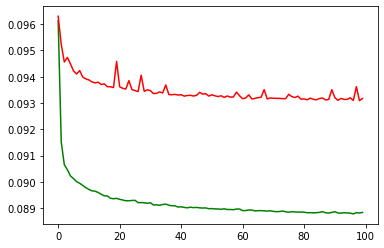

In [28]:
# plot training & validation losses
# print(train_losses[0:10])
plt.plot(train_losses,"g", val_losses, "r")
# plt.ylim(0.0, 1000000)
plt.show()

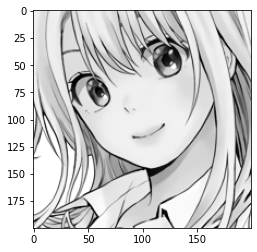

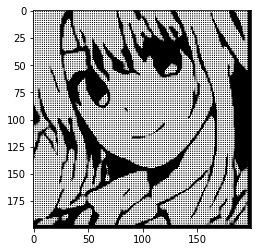

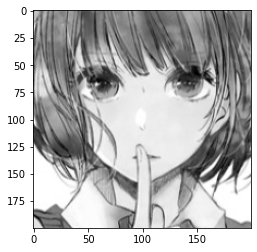

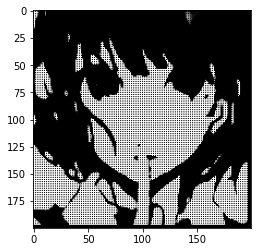

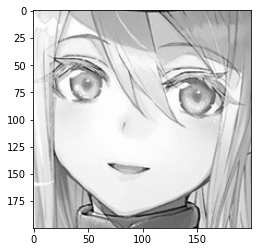

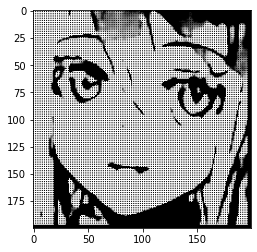

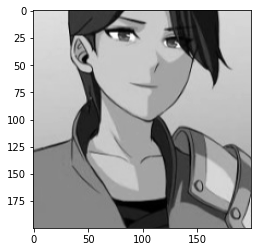

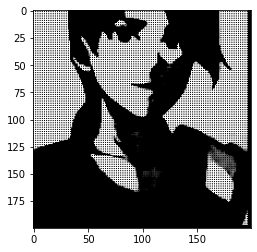

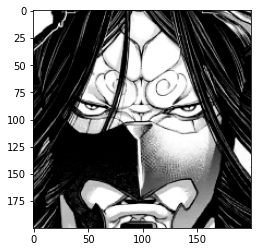

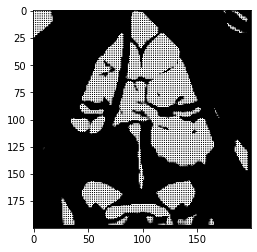

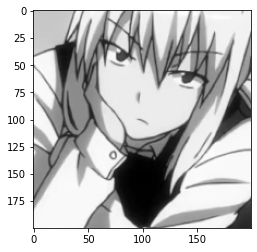

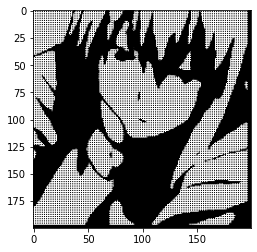

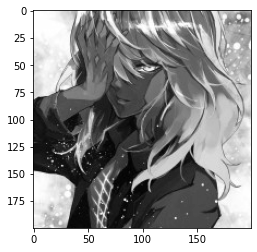

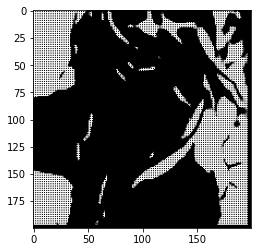

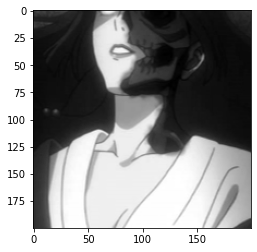

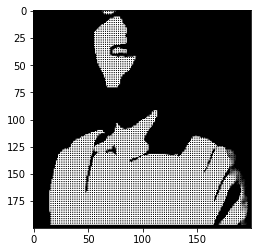

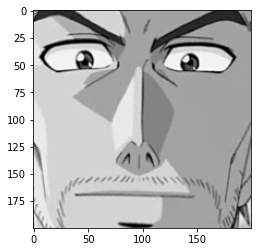

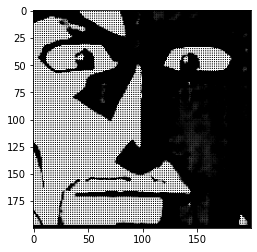

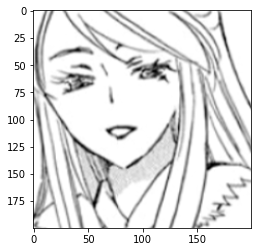

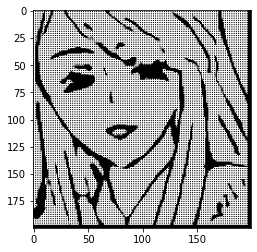

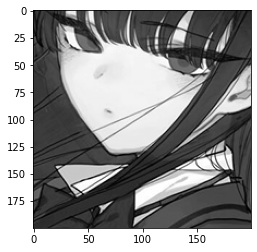

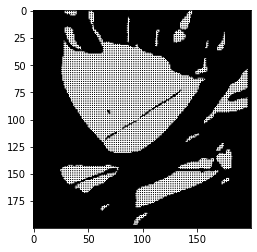

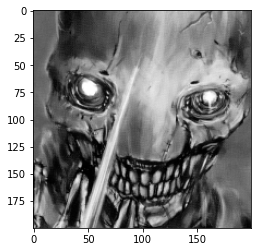

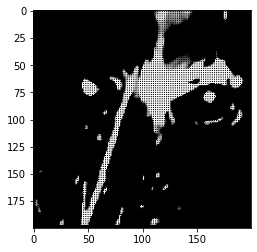

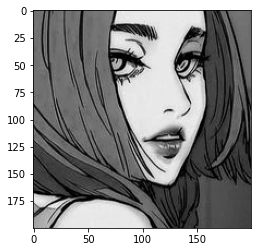

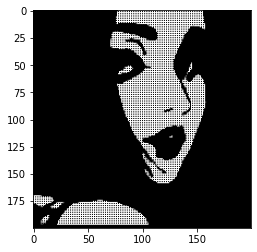

In [29]:
# show what the model learned -> look how validation images are now represented by the decoder
# if the model learned the images well, they should look similar to each other

# Note: 
# when training loss doesn't go down (10 epochs, ~0.4 loss at minimum) -> dec_output is all BLACK and can't see anything
# when training loss goes down (50 epochs, ~0.04) -> dec_output is blurry but somewhat similar to the input

model.eval()
with torch.no_grad():
    for train_img, target_img, _ in val_loader:
        
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        out = model(train_img)
        
        # show only the first image of each batch (output original and decoder output images for comparison)
        for t_img, out_img in zip(train_img[0], out[0]):
            plt.imshow(t_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()
            plt.imshow(out_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()

---
## Create embedding
---

In [30]:
# create embedding

model.eval()
embedding = torch.zeros((1, 512, 12, 12))
character_ids = []
with torch.no_grad():
    for train_img, target_img, character_id in tqdm(all_data_loader):
        train_img = train_img.to(device)
        out = model.encoder(train_img).cpu()
        embedding = torch.cat((embedding, out), 0)
        character_ids.append(character_id)

100%|██████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


In [31]:
# Convert to numpy and save
character_ids = list(itertools.chain.from_iterable(character_ids))
np_character_ids = np.array(character_ids)
embedding = embedding[1:, :]
print("len of character_ids: ", len(character_ids))
print("shape of embedding: ", embedding.shape)
np_embedding = embedding.cpu().detach().numpy()
num_images = np_embedding.shape[0]

# Save the embeddings
flattened_embedding = np_embedding.reshape((num_images, -1))
print("shape of flattened embedding: ", flattened_embedding.shape)
np.save("../assets/character_images/models_and_embeddings/image_embedding_"+version+".npy", flattened_embedding)
np.save("../assets/character_images/models_and_embeddings/image_embedding_character_ids_"+version+".npy", np_character_ids)

len of character_ids:  2000
shape of embedding:  torch.Size([2000, 512, 12, 12])
shape of flattened embedding:  (2000, 73728)


In [61]:
character_ids[100:110]

['40881',
 '81919',
 '83699',
 '200389',
 '279938',
 '22321',
 '6645',
 '261639',
 '79441',
 '41607']

---
## Similarity calculations (Character-based, Title-based)
---

In [32]:
class ImageBasedRecommendation:
    def __init__(self, query_path, version):
        print("model version: ", version)
        self.embedding_flat_np = np.load("../assets/character_images/models_and_embeddings/image_embedding_"+version+".npy") 
        self.embedding_ids = np.load("../assets/character_images/models_and_embeddings/image_embedding_character_ids_"+version+".npy") 
        self.df_characters = pd.read_csv("../assets/characters_200p.csv")
        self.query_path = query_path

        # create character_based similarity matrix
        self.df_chara_sim_mat = pd.DataFrame(cosine_similarity(self.embedding_flat_np))
        self.df_chara_sim_mat.index = self.embedding_ids
        self.df_chara_sim_mat.columns = self.embedding_ids

        # create title_based similarity matrix
        np_embedding_id_concat = np.c_[self.embedding_ids.astype(int), self.embedding_flat_np] # create character_id:embeddings table
        df_embedding = pd.DataFrame(np_embedding_id_concat)
        df_embedding.rename(columns={0:"character_id"}, inplace=True)
        df_characters_unique = self.df_characters.drop_duplicates(subset="character_id") 
        df_title_char = df_characters_unique[["title_id", "character_id"]] # get character:title reference table
        df_merged = pd.merge(df_title_char, df_embedding, how="inner", on="character_id")
        df_title_embedding_avg = df_merged.groupby("title_id").mean() # merge and calculate "average" of image features
        self.df_title_sim_mat = pd.DataFrame(cosine_similarity(df_title_embedding_avg.iloc[:, 1:])) # similarity calculation of titles
        self.df_title_sim_mat.index = df_title_embedding_avg.index
        self.df_title_sim_mat.columns = df_title_embedding_avg.index

    def recommend_titles_from_similar_characters(self, query_character_id, top_n):
        # show the querying character
        df_q = self.df_characters[self.df_characters["character_id"]==query_character_id]
        print("Queried character: ", df_q["character_name"].unique(), " who appears in: ", df_q["title_romaji"].unique())
        img = Image.open(self.query_path + str(query_character_id) + ".png")
        plt.imshow(np.array(img), cmap="gray")
        plt.show()

        # get similar character
        df = self.df_chara_sim_mat[str(query_character_id)].sort_values(ascending=False)
        df_top = df[1:top_n+1]
        top_ids = list(df_top.index.astype(int))
        plot_images(self.query_path, top_ids)
        
        # print character names
        print("Similar characters (in the order of appearance)")
        for chara_id in top_ids:
            df_recc = self.df_characters[self.df_characters["character_id"]==int(chara_id)]
            print("Character: ", df_recc["character_name"].unique(), " who appears in : ", df_recc["title_romaji"].unique())

        # get titles that each similar character appears in
        df_res = self.df_characters[self.df_characters["character_id"].isin(top_ids)]
        df_res = df_res.drop_duplicates(subset="character_name")
        recc_title_ids = df_res["title_id"].unique()
        
        return recc_title_ids

    def recommend_titles_from_similar_image_embedding(self, query_title_id, top_n):
        # query title and pull out similar titles
        df = self.df_title_sim_mat[query_title_id].sort_values(ascending=False)
        df_top = df[0:top_n+1]
        top_ids = df_top.index

        # get images for comparison
        for idx, id in enumerate(top_ids):
            df = self.df_characters[self.df_characters["title_id"]==id]
            if idx == 0:
                print("Querying title: ", df["title_romaji"].unique())
            else:
                print("Similar title: ", df["title_romaji"].unique())
            character_ids = df["character_id"].unique()
            plot_images(self.query_path, character_ids)

        return list(top_ids[1:]) # exclude first element as it's the queried title


In [38]:
ibr_search = ImageBasedRecommendation("../assets/character_images/character_images_grayscale_2000/", "v6_1")

model version:  v6_1


Queried character:  ['Mikasa Ackerman']  who appears in:  ['Shingeki no Kyojin' 'Shingeki no Kyojin: LOST GIRLS'
 'Shingeki! Kyojin Chuugakkou' 'Sungeki no Kyojin'
 'Shingeki! Kyojin Chuugakkou: Seishun! Tonari no Marley Gakuen']


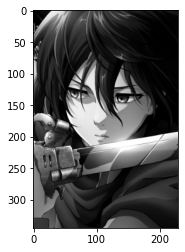

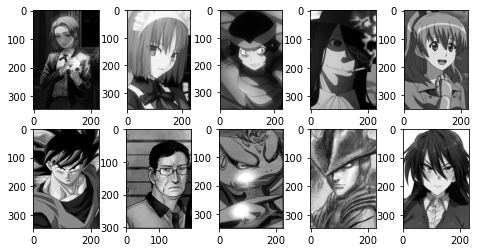

Similar characters (in the order of appearance)
Character:  ['Yoo-Sung Shin']  who appears in :  ['Jeonjijeok Dokja Sijeom']
Character:  ['Hisui']  who appears in :  ['Shingetsutan Tsukihime' 'Melty Blood' 'ALL AROUND TYPE-MOON' 'Take Moon'
 'Melty Blood X']
Character:  ['Sasamaru']  who appears in :  ['Sword Art Online']
Character:  ['Joker']  who appears in :  ['Enen no Shouboutai']
Character:  ['Seryuu Ubiquitous']  who appears in :  ['Akame ga Kill!' 'Akame ga Kill! 1.5']
Character:  ['Goku Son']  who appears in :  ['Dragon Ball' 'Dragon Ball Gaiden: Tensei-shitara Yamcha Datta Ken'
 'Ginga Patrol Jako' 'Cross Epoch' 'Dragon Ball Z: Fukkatsu no "F"'
 'Jump Super Stars' 'Neko Majin' 'Dragon Ball SD'
 'Dragon Ball Super: Broly'
 'Dragon Ball: Heya! Son Goku and His Friends Return!!'
 'Dragon Ball Minus: Hanatareta Unmei no Kodomo']
Character:  ['Shigemasa Kusunoki']  who appears in :  ['BTOOOM!']
Character:  ['Gamakichi']  who appears in :  ['NARUTO' 'Rock Lee no Seishun Full-Power N

In [63]:
res = ibr_search.recommend_titles_from_similar_characters(query_character_id=40881, top_n=10)
print(res)

Querying title:  ['MONSTER']


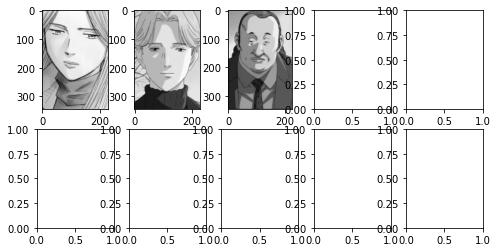

Similar title:  ['SPY×FAMILY']


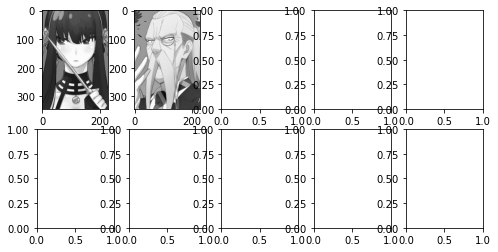

Similar title:  ['BECK']


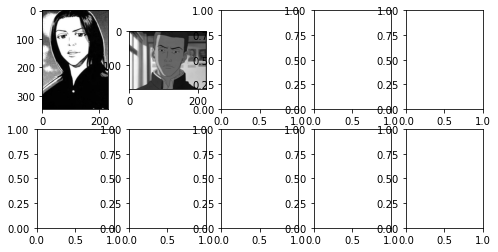

Similar title:  ['NARUTO']


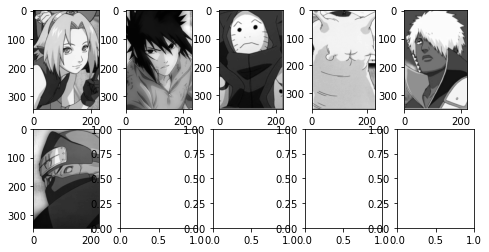

[108556, 30145, 30011]


In [64]:
res = ibr_search.recommend_titles_from_similar_image_embedding(query_title_id=30001, top_n=3)
print(res)